# Track model training, save, and upload
The purpose of this chapter is to show how to store an elementary log of model training/validation, how to store model weights, and how to retrieve them for inference or re-training.

In [1]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')

## A standard regression model
This is an elementary implementation of a regression model in Pytorch. we will use the procedure introduced in previous notebooks to define and train the model.

The data frame is the linear relationship without noise, we explicitly split the data frame into training/validation/test set.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device:", device)

Device: cpu


In [3]:
chosen_df = "df_linear.csv"

full_df = pd.read_csv(os.path.join(path_data, chosen_df))

training_df = full_df[full_df["split_label"]==0]
validation_df = full_df[full_df["split_label"]==1]
test_df = full_df[full_df["split_label"]==2]

In [4]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, path_data, split_label=None):
        if split_label!=None:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))
            self.df = self.df[self.df['split_label']==split_label]
        else:
            self.df = pd.read_csv(os.path.join(path_data, annotations_file))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_range = float(self.df.iloc[idx]['x_range'])
        y_range = float(self.df.iloc[idx]['y_range'])

        features = torch.tensor([x_range], dtype=torch.float32)
        output = torch.tensor([y_range], dtype=torch.float32)
        
        return features, output

# Initialize Training dataset and show outputs and properties:
training_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=0)
print("Length training dataset:", training_dataset.__len__())

# Initialize validation and test datasets:
validation_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=1)
test_dataset = CustomDataset(annotations_file=chosen_df, path_data=path_data, split_label=2)

Length training dataset: 160


In [5]:
# Size of each batch
batch_size = 30  

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Introduce a (small) model to approximate the relationship:

In [6]:
# Define the model:
model = nn.Sequential(
    nn.Linear(1, 4),
    nn.ReLU(),
    nn.Linear(4,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

# Move the model to device (GPU):
model.to(device)

# Convert weights type to float:
model = model.float()

# Save the initial state of the model
The initial state of the model can be stored in such a way that the random initialisation of the weights is preserved and the model training is (more) reproducible.

Pytorch allows to save model *weights* or model *architecture*. The first approach uses less memory and is generally PyTorch version independent, but requires the model structure to be redefined in code.

In [7]:
# Define the save path:
path_save_model_weights = os.path.join(path_data, "linear_model_initial_weights.pth")

# Save model weights
torch.save(model.state_dict(), path_save_model_weights)

# Load weigths - it requires to have already defined a model structure - weights_only will be set True as default in next pytorch releases
model.load_state_dict(torch.load(path_save_model_weights, weights_only=True)) 

<All keys matched successfully>

In [8]:
# Define the save path:
path_save_model_architecture = os.path.join(path_data, "linear_model_initial_architecture.pth")

#Save model and architecture
torch.save(model, path_save_model_architecture)

# Load the model and move it to the appropriate device
model_2 = torch.load(path_save_model_architecture, map_location=device)

C:\Users\Giulio Del Corso\AppData\Local\Temp\ipykernel_20612\2328770123.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2 = torch.load(path_save_model_architecture

## Train the model, track the log and save the ending state

In [9]:
# Loss function (Mean Squared Error):
loss_fn = nn.MSELoss()  

# Optimizer (Adam): 
learning_rate = 1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

During the training cycle, we want to store model weights (every tot backup_epoch) in order to restart training if necessary or to upload a model after a certain number of epochs.

We also want to keep a log of the behaviour of the training loss and validation loss. An elementary but effective log is to save a dataframe including the epoch, validation loss and training loss (every tot backup_epoch).

In [10]:
# Save the log and the model every backup_epoch
backup_epoch = 5
path_intermediate_model = os.path.join(path_data, "intermediate_models_step_6")
df_log = pd.DataFrame(columns=["Epoch", "Training loss", "Validation loss"]) # Empty log
path_log = os.path.join(path_data, "intermediate_models_step_6", 'log.csv')

if not os.path.isdir(path_intermediate_model):
    os.mkdir(path_intermediate_model)

# Number of training epochs:
n_epochs = 100

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for x_input, y_output in training_dataloader:
        # Load inputs ad move to device (GPU)
        x_input, y_output = x_input.to(device), y_output.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        y_model = model(x_input)  

        # Compute loss (supervised case)
        loss = loss_fn(y_model, y_output)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for x_input, y_output in validation_dataloader:
            # Load inputs ad move to device (GPU)
            x_input, y_output = x_input.to(device), y_output.to(device)

        
            # Forward pass (model calls)
            y_model = model(x_input)

            # Compute loss (supervised case)
            loss = loss_fn(y_model, y_output)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            
    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

    # Append the values to the log
    df_log.loc[len(df_log)] = [epoch+1, epoch_training_loss, epoch_validation_loss]

    # If we are at a backup epoch, save the model and the log
    if (epoch+1)%backup_epoch==0:
        print("Save intermediate state\n")
        
        # Save log
        df_log.to_csv(path_log, index=False)

        # Save model weights
        torch.save(model.state_dict(), os.path.join(path_intermediate_model, "linear_model_intermediated"+str(epoch+1)+".pth"))

Epoch [1/100], Loss: 12595.0965, Val. Loss: 13174.6404
Epoch [2/100], Loss: 11322.0223, Val. Loss: 12337.3671
Epoch [3/100], Loss: 10897.2188, Val. Loss: 10982.5356
Epoch [4/100], Loss: 9602.1248, Val. Loss: 8948.3580
Epoch [5/100], Loss: 7702.0872, Val. Loss: 6257.1142
Save intermediate state

Epoch [6/100], Loss: 4687.7179, Val. Loss: 3301.0431
Epoch [7/100], Loss: 2481.2455, Val. Loss: 1322.5784
Epoch [8/100], Loss: 943.2908, Val. Loss: 429.7191
Epoch [9/100], Loss: 242.6386, Val. Loss: 231.0326
Epoch [10/100], Loss: 274.2060, Val. Loss: 182.5233
Save intermediate state

Epoch [11/100], Loss: 102.8503, Val. Loss: 34.2352
Epoch [12/100], Loss: 37.2961, Val. Loss: 65.0815
Epoch [13/100], Loss: 61.9178, Val. Loss: 47.3760
Epoch [14/100], Loss: 26.8353, Val. Loss: 13.3108
Epoch [15/100], Loss: 16.6258, Val. Loss: 20.4612
Save intermediate state

Epoch [16/100], Loss: 20.4469, Val. Loss: 14.5648
Epoch [17/100], Loss: 12.8762, Val. Loss: 12.6180
Epoch [18/100], Loss: 12.8888, Val. Loss: 1

Plot the convergence graphs on training and validation sets:

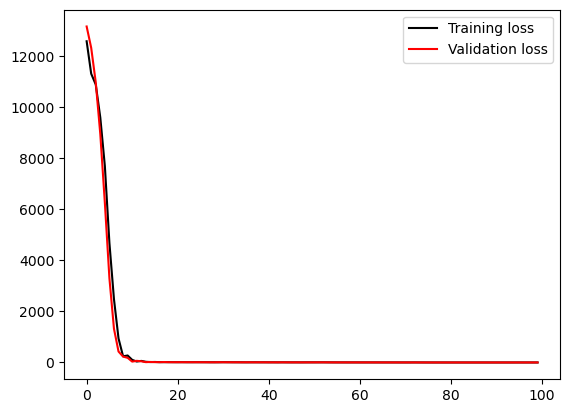

In [11]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

Plot the training dataset against the predictions:

<Axes: xlabel='x', ylabel='y'>

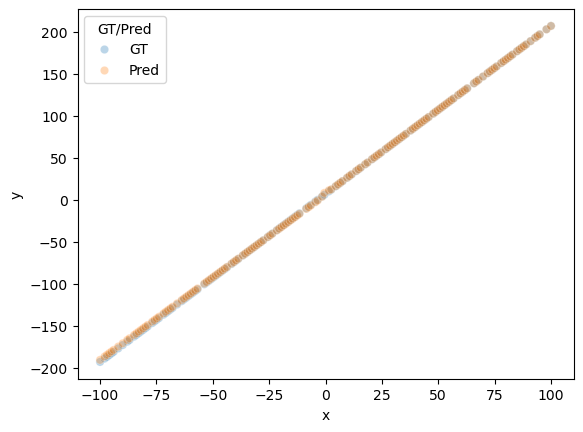

In [12]:
# Define the dataframe 
x_plot = np.array(training_df["x_range"]) # Input
y_plot = np.array(training_df["y_range"]) # GT
prediction_plot = [float(model(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_train = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_train, x="x", y="y", hue="GT/Pred", alpha = 0.3)

Save the ending state of the model for future use:

In [13]:
# Define the save path:
path_save_model_weights = os.path.join(path_data, "linear_model_final_weights.pth")

# Save model weights
torch.save(model.state_dict(), path_save_model_weights)

## Load model and inference
We want to load the model for inference. We have only saved the weights, so we need to define the architecture first and then load the weights into the model.

In [14]:
# Define the architecture
model_inference = nn.Sequential(
    nn.Linear(1, 4),
    nn.ReLU(),
    nn.Linear(4,8),
    nn.ReLU(),
    nn.Linear(8,4),
    nn.ReLU(),
    nn.Linear(4, 1)
)
model_inference.to(device)
model_inference = model.float()

# Load weigths
model_inference.load_state_dict(torch.load(path_save_model_weights, weights_only=True)) 

<All keys matched successfully>

The model can now be used to do inference on unseen data:

<Axes: xlabel='x', ylabel='y'>

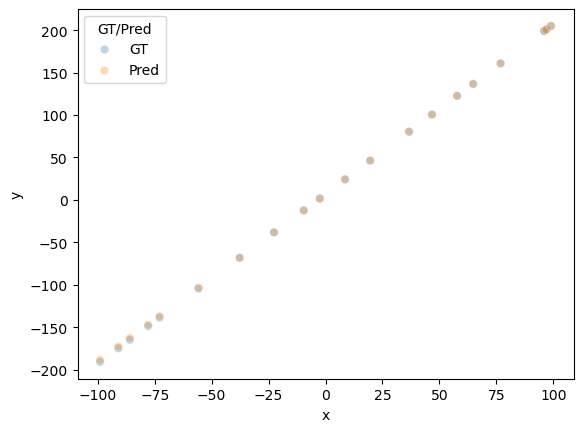

In [15]:
# Define the dataframe 
x_plot = np.array(test_df["x_range"]) # Input
y_plot = np.array(test_df["y_range"]) # GT
prediction_plot = [float(model_inference(torch.tensor(i).view(1).to(device).float()).to('cpu')) for i in x_plot] # Predictions

df_plot_test = pd.DataFrame({"x":np.append(x_plot,x_plot),"y":np.append(y_plot,prediction_plot),"GT/Pred":np.append(["GT"]*len(y_plot), ["Pred"]*len(prediction_plot))})
                         
# Scatter plot
sns.scatterplot(data=df_plot_test, x="x", y="y", hue="GT/Pred", alpha = 0.3)